**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn import preprocessing

import seaborn
seaborn.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

## Importar el dataset "curado" del entregable 1.

Se debe tocar el botón "Chosee Files"(Elegir archivos) que aparece al ejecutar la celda de código a continuación, para así poder cargar desde el explorador de archivos local, el dataset "merged_sales_df.pkl". Este archivo es el que se obtiene luego de ejecutar el Entregable 1, el cual ya tiene la curación de datos realizada.



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving merged_sales_df.pkl to merged_sales_df (1).pkl


In [ ]:
import io
melb_df_raw = pd.read_pickle(io.BytesIO(uploaded['merged_sales_df.pkl']))
melb_df = melb_df_raw.copy()
melb_df[:3]

,Rooms,Type,Price,Distance,Car,Landsize,BuildingArea,YearBuilt,reg_cat,Suburb_cat,airbnb_price_mean,airbnb_weekly_price_mean,airbnb_monthly_price_mean
0,2.0,h,1480000.0,2.0,1.0,202.0,NaN,NaN,Northern Metropolitan,Suburb_group8,131.0,605.0,2187.0
1,2.0,h,1035000.0,2.0,0.0,156.0,79.0,1900.0,Northern Metropolitan,Suburb_group8,131.0,605.0,2187.0
2,3.0,h,1465000.0,2.0,0.0,134.0,150.0,1900.0,Northern Metropolitan,Suburb_group8,131.0,605.0,2187.0


In [ ]:
melb_df.isnull().sum()/len(melb_df)*100

Rooms                         0.000000
Type                          0.000000
Price                         0.000000
Distance                      0.000000
Car                           0.000000
Landsize                      0.000000
BuildingArea                 47.638497
YearBuilt                    39.551463
reg_cat                       0.000000
Suburb_cat                    0.000000
airbnb_price_mean             0.000000
airbnb_weekly_price_mean      0.000000
airbnb_monthly_price_mean     0.000000
dtype: float64

## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


Reorganizamos las columnas para que esten primero todas las numéricas y luego las categóricas.

In [ ]:
melb_df = melb_df.rename({
    'airbnb_monthly_price_mean':'PriceMonthlyMeanAirbnb',
    'airbnb_price_mean':'PriceMeanAirbnb',
    'airbnb_weekly_price_mean':'PriceWeeklyMeanAirbnb'
}, axis=1)

In [ ]:
numerical_cols = [
    'YearBuilt', 'BuildingArea', 'Car', 'Distance', 
    'Landsize', 'Price', 'Rooms', 'PriceMonthlyMeanAirbnb', 
    'PriceMeanAirbnb', 'PriceWeeklyMeanAirbnb'
]

In [ ]:
columns = melb_df.columns.to_list()
for col in numerical_cols:
    if col in columns:
        columns.remove(col)
columns = numerical_cols + columns
columns

['YearBuilt',
 'BuildingArea',
 'Car',
 'Distance',
 'Landsize',
 'Price',
 'Rooms',
 'PriceMonthlyMeanAirbnb',
 'PriceMeanAirbnb',
 'PriceWeeklyMeanAirbnb',
 'Type',
 'reg_cat',
 'Suburb_cat']

In [ ]:
melb_df = melb_df.reindex(columns, axis=1)
melb_df.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Type,reg_cat,Suburb_cat
0,NaN,NaN,1.0,2.0,202.0,1480000.0,2.0,2187.0,131.0,605.0,h,Northern Metropolitan,Suburb_group8
1,1900.0,79.0,0.0,2.0,156.0,1035000.0,2.0,2187.0,131.0,605.0,h,Northern Metropolitan,Suburb_group8
2,1900.0,150.0,0.0,2.0,134.0,1465000.0,3.0,2187.0,131.0,605.0,h,Northern Metropolitan,Suburb_group8
3,NaN,NaN,1.0,2.0,94.0,850000.0,3.0,2187.0,131.0,605.0,h,Northern Metropolitan,Suburb_group8
4,2014.0,142.0,2.0,2.0,120.0,1600000.0,4.0,2187.0,131.0,605.0,h,Northern Metropolitan,Suburb_group8


Tomamos las columnas de nuestro dataframe y descartamos las columnas `YearBuilt` y `BuildingArea` para la codificación One Hot.

In [ ]:
melb_df_ohe = melb_df.drop(columns=['YearBuilt', 'BuildingArea'])

Seleccionamos la opción 2 (`DictVectorizer`): esta transformación es tan común que Scikit-lean implementa el transformador `DictVectorizer` que codifica automáticamente todas las columnas categóricas y las combina con los datos numéricos existentes.

Para poder utilizarlo, tendremos que convertir el conjunto de datos en una lista de diccionarios.

In [ ]:
feature_dict = list(melb_df_ohe.T.to_dict().values())
feature_dict[:2]

[{'Car': 1.0,
  'Distance': 2.0,
  'Landsize': 202.0,
  'Price': 1480000.0,
  'PriceMeanAirbnb': 131.0,
  'PriceMonthlyMeanAirbnb': 2187.0,
  'PriceWeeklyMeanAirbnb': 605.0,
  'Rooms': 2.0,
  'Suburb_cat': 'Suburb_group8',
  'Type': 'h',
  'reg_cat': 'Northern Metropolitan'},
 {'Car': 0.0,
  'Distance': 2.0,
  'Landsize': 156.0,
  'Price': 1035000.0,
  'PriceMeanAirbnb': 131.0,
  'PriceMonthlyMeanAirbnb': 2187.0,
  'PriceWeeklyMeanAirbnb': 605.0,
  'Rooms': 2.0,
  'Suburb_cat': 'Suburb_group8',
  'Type': 'h',
  'reg_cat': 'Northern Metropolitan'}]

In [ ]:
vec = DictVectorizer()
feature_matrix = vec.fit_transform(feature_dict)
feature_matrix

<13466x26 sparse matrix of type '<class 'numpy.float64'>'
	with 148126 stored elements in Compressed Sparse Row format>

Para aplicar algunas transformaciones o modelos es necesario convertir las matrices esparsas a densas. Antes de realizar este cambio, es recomendable calcular el tamaño de la matriz final. Recordar que cada número de punto flotante ocupa 4 bytes para la precisión simple (`numpy.float32`) y 8 bytes para la precisión doble (`numpy.float64`).

In [ ]:
matrix_size_mb = feature_matrix.shape[0] * feature_matrix.shape[1] * 4 / 1024 / 1024
print("The dense matrix will weight approximately {:.2f} MB".format(
    matrix_size_mb))

limit_size_mb = 10
precision_type = numpy.float32
if matrix_size_mb < limit_size_mb:
    print("Matrix is less than 10MB")
    dense_feature_matrix = feature_matrix.astype(precision_type).todense()
else:
    n_rows = int(limit_size_mb *1024 * 1024 / 4 / feature_matrix.shape[1])
    print("Matrix too big! Using only first {} of {} rows".format(
        n_rows, feature_matrix.shape[0]))
print("Final size: {:.2f}".format(dense_feature_matrix.nbytes / 1024 / 1024))


The dense matrix will weight approximately 1.34 MB
Matrix is less than 10MB
Final size: 1.34


La matriz densa pesa menos de 10MB, podemos utilizarla completa.

El nuevo tamaño después de aplicar la codificación es el siguiente. Seguimos manteniendo la misma cantidad de filas.

In [ ]:
dense_feature_matrix.shape

(13466, 26)

Finalmente nuestro dataframe queda codificado de la siguiente forma:

In [ ]:
pd.DataFrame(dense_feature_matrix, columns=vec.get_feature_names()).head()

,Car,Distance,Landsize,Price,PriceMeanAirbnb,PriceMonthlyMeanAirbnb,PriceWeeklyMeanAirbnb,Rooms,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,1.0,2.0,202.0,1480000.0,131.0,2187.0,605.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,2.0,156.0,1035000.0,131.0,2187.0,605.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,2.0,134.0,1465000.0,131.0,2187.0,605.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,2.0,94.0,850000.0,131.0,2187.0,605.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2.0,2.0,120.0,1600000.0,131.0,2187.0,605.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

1. Agregamos nuevamente las columnas `YearBuilt` y `BuildingArea` para realizar la imputación de datos faltantes sobre éstas. Para esto usaremos `numpy.hstack`.

In [ ]:
columns = ['YearBuilt', 'BuildingArea']
columns = columns + vec.get_feature_names()
melb_data_mice = numpy.hstack((melb_df[['YearBuilt', 'BuildingArea']].values, dense_feature_matrix))
pd.DataFrame(melb_data_mice, columns=columns).head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,PriceMeanAirbnb,PriceMonthlyMeanAirbnb,PriceWeeklyMeanAirbnb,Rooms,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,NaN,NaN,1.0,2.0,202.0,1480000.0,131.0,2187.0,605.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1900.0,79.0,0.0,2.0,156.0,1035000.0,131.0,2187.0,605.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1900.0,150.0,0.0,2.0,134.0,1465000.0,131.0,2187.0,605.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,1.0,2.0,94.0,850000.0,131.0,2187.0,605.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2014.0,142.0,2.0,2.0,120.0,1600000.0,131.0,2187.0,605.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
melb_data_mice.shape

(13466, 28)

2. Aplicamos una instancia de `IterativeImputer` de `sklearn` que utiliza el algoritmo MICE (Multivariate Imputation by Chained Equations), con un estimador por vecinos más cercanos (`KNeighborsRegressor`) para imputar los valores de las variables.

Es recomendable estandarizar o al menos escalar la matriz original para quitar el peso de las diferencias entre unidades.

Con esto logramos que los datos queden en un rango comparable, centrados y escalados con su propia desviación estándar.

In [ ]:
melb_data_mice = pd.DataFrame(melb_data_mice, columns=columns)

In [ ]:
standard_scaler = preprocessing.StandardScaler() 
x_standarized = standard_scaler.fit_transform(melb_data_mice[numerical_cols]) 
melb_data_mice_standarized = pd.DataFrame(x_standarized, columns=numerical_cols) 
melb_data_mice_standarized.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb
0,NaN,NaN,-0.642001,-1.382354,-0.286843,0.657168,-0.997748,-0.269126,-0.004562,-0.295736
1,-1.786746,-0.752222,-1.726445,-1.382354,-0.319553,-0.054079,-0.997748,-0.269126,-0.004562,-0.295736
2,-1.786746,0.079499,-1.726445,-1.382354,-0.335197,0.633193,0.093076,-0.269126,-0.004562,-0.295736
3,NaN,NaN,-0.642001,-1.382354,-0.363640,-0.349766,0.093076,-0.269126,-0.004562,-0.295736
4,1.354823,-0.014216,0.442443,-1.382354,-0.345152,0.848965,1.183899,-0.269126,-0.004562,-0.295736


In [ ]:
melb_data_mice_standarized = pd.concat([melb_data_mice_standarized, melb_data_mice.drop(numerical_cols, axis=1)], axis=1)

Creamos la instancia del iterador con una semilla para que nuestro resultado no varíe entre distintas ejecuciones.

In [ ]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

### **Método de imputación 1**

Ahora imputamos los datos faltantes únicamente con las columnas `YearBuilt` y `BuildingArea`.

In [ ]:
yb_ba = mice_imputer.fit_transform(
    melb_data_mice_standarized[['YearBuilt', 'BuildingArea']]
)
melb_with_yb_ba = pd.DataFrame(yb_ba, columns=['YearBuilt', 'BuildingArea'])
melb_with_yb_ba = pd.concat([melb_with_yb_ba, melb_data_mice_standarized.drop(['YearBuilt', 'BuildingArea'], axis=1)], axis=1)
melb_with_yb_ba.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,-0.023058,2.487973,-0.642001,-1.382354,-0.286843,0.657168,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.786746,-0.752222,-1.726445,-1.382354,-0.319553,-0.054079,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.786746,0.079499,-1.726445,-1.382354,-0.335197,0.633193,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.023058,2.487973,-0.642001,-1.382354,-0.363640,-0.349766,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.354823,-0.014216,0.442443,-1.382354,-0.345152,0.848965,1.183899,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
melb_with_yb_ba.isnull().sum()

YearBuilt                        0
BuildingArea                     0
Car                              0
Distance                         0
Landsize                         0
Price                            0
Rooms                            0
PriceMonthlyMeanAirbnb           0
PriceMeanAirbnb                  0
PriceWeeklyMeanAirbnb            0
Suburb_cat=Suburb_group1         0
Suburb_cat=Suburb_group10        0
Suburb_cat=Suburb_group2         0
Suburb_cat=Suburb_group3         0
Suburb_cat=Suburb_group4         0
Suburb_cat=Suburb_group5         0
Suburb_cat=Suburb_group6         0
Suburb_cat=Suburb_group7         0
Suburb_cat=Suburb_group8         0
Suburb_cat=Suburb_group9         0
Type=h                           0
Type=t                           0
Type=u                           0
reg_cat=Eastern Metropolitan     0
reg_cat=Northern Metropolitan    0
reg_cat=Southern Metropolitan    0
reg_cat=Victoria                 0
reg_cat=Western Metropolitan     0
dtype: int64

### **Método de imputación 2**

Ahora imputamos los datos faltantes utilizando todas las columnas numéricas del dataframe, incluyendo `YearBuilt` y `BuildingArea`.

In [ ]:
all_df = mice_imputer.fit_transform(melb_data_mice_standarized) 
melb_with_all = pd.DataFrame(all_df, columns=melb_data_mice_standarized.columns)
melb_with_all.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,-0.364773,-0.560106,-0.642001,-1.382354,-0.286843,0.657168,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.786746,-0.752222,-1.726445,-1.382354,-0.319553,-0.054079,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.786746,0.079499,-1.726445,-1.382354,-0.335197,0.633193,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.563188,-0.457020,-0.642001,-1.382354,-0.363640,-0.349766,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.354823,-0.014216,0.442443,-1.382354,-0.345152,0.848965,1.183899,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

Armamos un dataframe recuperando las unidades de las variables del dataframe original estandarizado, sin imputar los nulos de las columnas `YearBuilt` y `BuildingArea`, para ser utilizado gráficamente.

In [ ]:
melb_data_mice_inversed = standard_scaler.inverse_transform(melb_data_mice_standarized[numerical_cols])

In [ ]:
melb_data_mice_inversed = pd.concat([pd.DataFrame(melb_data_mice_inversed, columns=numerical_cols), melb_data_mice_standarized.drop(numerical_cols, axis=1)], axis=1)
melb_data_mice_inversed.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,NaN,NaN,1.0,2.0,202.0,1480000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1900.0,79.0,0.0,2.0,156.0,1035000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1900.0,150.0,0.0,2.0,134.0,1465000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,1.0,2.0,94.0,850000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2014.0,142.0,2.0,2.0,120.0,1600000.0,4.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Armamos un nuevo dataframe recuperando las unidades de las variables, del dataframe obtenido con el método de imputación 1, para ser utilizado gráficamente.

In [ ]:
yb_ba_inversed = standard_scaler.inverse_transform(melb_with_yb_ba[numerical_cols])

In [ ]:
yb_ba_inversed = pd.concat([pd.DataFrame(yb_ba_inversed, columns=numerical_cols), melb_data_mice_standarized.drop(numerical_cols, axis=1)], axis=1)
yb_ba_inversed.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,1964.0,355.6,1.0,2.0,202.0,1480000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1900.0,79.0,0.0,2.0,156.0,1035000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1900.0,150.0,0.0,2.0,134.0,1465000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1964.0,355.6,1.0,2.0,94.0,850000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2014.0,142.0,2.0,2.0,120.0,1600000.0,4.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Armamos un nuevo dataframe recuperando las unidades de las variables, del dataframe obtenido con el método de imputación 2, para ser utilizado gráficamente.

In [ ]:
melb_with_all_inversed = standard_scaler.inverse_transform(melb_with_all[numerical_cols])

In [ ]:
melb_with_all_inversed = pd.concat([pd.DataFrame(melb_with_all_inversed, columns=numerical_cols), melb_data_mice_standarized.drop(numerical_cols, axis=1)], axis=1)
melb_with_all_inversed.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan
0,1951.6,95.4,1.0,2.0,202.0,1480000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1900.0,79.0,0.0,2.0,156.0,1035000.0,2.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1900.0,150.0,0.0,2.0,134.0,1465000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1944.4,104.2,1.0,2.0,94.0,850000.0,3.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2014.0,142.0,2.0,2.0,120.0,1600000.0,4.0,2187.0,131.0,605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Comparamos los resultados obtenidos visualizando las distribuciones de la variable `YearBuilt` en las siguientes situaciones:
- sin imputar los nulos;
- imputando sus valores nulos con el método 1, utilizando sólo las columnas `YearBuilt` y `BuildingArea`;
- imputando sus valores nulos con el método 2, utilizando todas las variables del dataset.

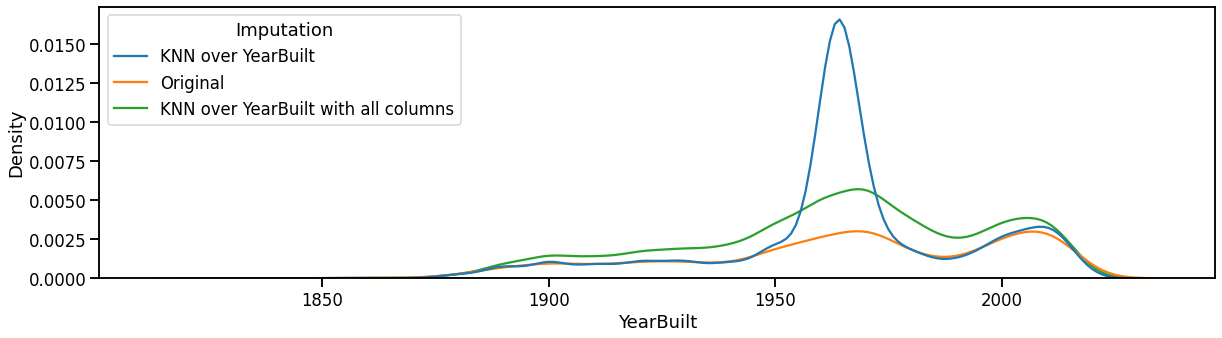

In [ ]:
mice_year_built_simple = yb_ba_inversed['YearBuilt'].to_frame()
mice_year_built_simple['Imputation'] = 'KNN over YearBuilt'
melb_year_built_original = melb_data_mice_inversed['YearBuilt'].dropna().to_frame()
melb_year_built_original['Imputation'] = 'Original'
melb_year_built_completo = melb_with_all_inversed['YearBuilt'].to_frame()
melb_year_built_completo['Imputation'] = 'KNN over YearBuilt with all columns'
data = pd.concat([mice_year_built_simple, melb_year_built_original, melb_year_built_completo])
fig = plt.figure(figsize=(20, 5))
seaborn.kdeplot(data=data, x='YearBuilt', hue="Imputation")

Se observa que el método de imputación que considera sólo las dos variables (línea azul), concentra toda la densidad en un sector; mientras que el método que utiliza todas las columnas (línea verde), luego de la imputación conserva la forma de la función de densidad original (línea naranja). 
Por ello, seleccionamos los datos de 'YearBuilt' imputados con el segundo método (KNN over YearBuilt with all columns) para continuar nuestro análisis.

Comparamos ahora los resultados obtenidos visualizando las distribuciones de la variable `BuildingArea` en las siguientes situaciones:
- sin imputar los nulos;
- imputando sus valores nulos con el método 1, utilizando sólo las columnas `YearBuilt` y `BuildingArea`;
- imputando sus valores nulos con el método 2, utilizando todas las variables del dataset.

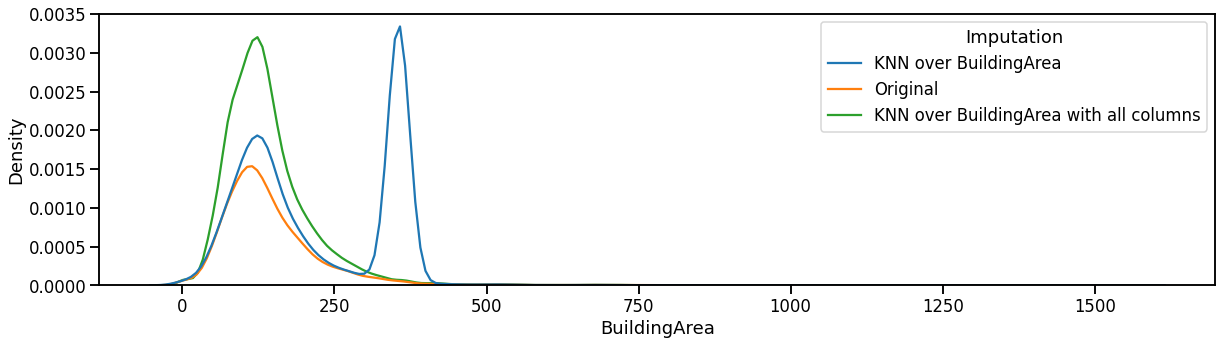

In [ ]:
mice_build_simple = yb_ba_inversed['BuildingArea'].to_frame()
mice_build_simple['Imputation'] = 'KNN over BuildingArea'
melb_build_original = melb_data_mice_inversed['BuildingArea'].dropna().to_frame()
melb_build_original['Imputation'] = 'Original'
melb_build_completo = melb_with_all_inversed['BuildingArea'].to_frame()
melb_build_completo['Imputation'] = 'KNN over BuildingArea with all columns'
data = pd.concat([mice_build_simple, melb_build_original, melb_build_completo])
fig = plt.figure(figsize=(20, 5))
seaborn.kdeplot(data=data, x='BuildingArea', hue="Imputation")

Se observa que el método de imputación que considera sólo las dos variables (línea azul), concentra toda la densidad en dos sectores y su forma se aleja de la distribución de la variable original sin imputar; mientras que el método que utiliza todas las columnas (línea verde), luego de la imputación conserva la forma de la función de densidad original (línea naranja). 
Por ello, seleccionamos los datos de 'BuildingArea' imputados con el segundo método (KNN over YearBuilt with all columns) para continuar nuestro análisis.

Agregamos al dataframe las varibles categóricas del One Hot Encoding.

In [ ]:
melb_with_all.columns

Index(['YearBuilt', 'BuildingArea', 'Car', 'Distance', 'Landsize', 'Price',
       'Rooms', 'PriceMonthlyMeanAirbnb', 'PriceMeanAirbnb',
       'PriceWeeklyMeanAirbnb', 'Suburb_cat=Suburb_group1',
       'Suburb_cat=Suburb_group10', 'Suburb_cat=Suburb_group2',
       'Suburb_cat=Suburb_group3', 'Suburb_cat=Suburb_group4',
       'Suburb_cat=Suburb_group5', 'Suburb_cat=Suburb_group6',
       'Suburb_cat=Suburb_group7', 'Suburb_cat=Suburb_group8',
       'Suburb_cat=Suburb_group9', 'Type=h', 'Type=t', 'Type=u',
       'reg_cat=Eastern Metropolitan', 'reg_cat=Northern Metropolitan',
       'reg_cat=Southern Metropolitan', 'reg_cat=Victoria',
       'reg_cat=Western Metropolitan'],
      dtype='object')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

1. Obtenemos la cantidad de componentes a calcular según la cantidad de columnas, no usaremos más de 20. Utilizamos datos estandarizados por las mismas razones explicadas en el ejercicio anterior.

Al entrenar la instancia de la clase PCA, sklearn se encarga de centrar los datos restandoles la media. Sin embargo, es recomendable también estandarizar o al menos escalar la matriz original.

In [ ]:
melb_with_all.shape[1]

28

In [ ]:
n = min(20, melb_with_all.shape[1])
n

20

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n)
pca.fit(melb_with_all)
pca_features = pca.transform(melb_with_all)
X_pca = numpy.hstack([melb_with_all, pca_features])

new_columns = list(melb_with_all.columns)
new_columns.extend(['pca' + str(i) for i in range(1, n+1)])
new_df = pd.DataFrame(data=X_pca, columns=new_columns)
new_df.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,-0.364773,-0.560106,-0.642001,-1.382354,-0.286843,0.657168,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.668336,-0.748737,-1.566600,0.369194,-0.510749,0.372069,0.291288,0.091514,0.305190,-0.653747,-0.598492,-0.195388,0.910994,0.327115,0.090909,-0.049935,0.167683,-0.109946,0.048828,-0.220413
1,-1.786746,-0.752222,-1.726445,-1.382354,-0.319553,-0.054079,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.045063,-1.386701,-2.505017,0.599514,0.678669,0.363830,-0.101049,-0.230416,0.326833,-0.327320,0.003015,-0.026043,0.779859,0.308901,0.122561,0.003400,0.106918,0.108744,0.147604,-0.296453
2,-1.786746,0.079499,-1.726445,-1.382354,-0.335197,0.633193,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.743715,-0.115760,-2.695501,0.618639,0.769171,0.075893,0.474087,-0.501434,0.262236,-0.332259,0.165376,0.110179,0.698038,0.310025,0.348356,-0.030662,0.066710,0.065424,0.135737,-0.251005
3,-0.563188,-0.457020,-0.642001,-1.382354,-0.363640,-0.349766,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.307620,-0.673439,-1.459172,0.183419,-0.245643,0.268787,0.202122,-0.892740,-0.106327,-0.381826,0.221800,-0.011490,0.820412,0.344815,-0.084024,-0.021043,0.229507,-0.023978,0.100334,-0.324098
4,1.354823,-0.014216,0.442443,-1.382354,-0.345152,0.848965,1.183899,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.380836,0.815257,-0.387451,-0.128175,-1.490544,-0.004099,1.201143,-0.916637,-0.638235,-0.880413,-0.396674,-0.158287,0.928200,0.378177,-0.018864,-0.106668,0.305948,-0.366153,-0.041389,-0.209801


In [ ]:
expl_var = pca.explained_variance_ratio_.round(6)*100
expl_var

array([23.6607, 20.6343, 11.0292,  8.2506,  6.0049,  5.7238,  5.0413,
        3.3748,  2.2758,  2.1507,  1.6696,  1.3197,  1.1995,  1.1014,
        0.9912,  0.9325,  0.8604,  0.8309,  0.7277,  0.6517])

2. Gráfico de la varianza capturada por los primeros $n$ componentes principales.

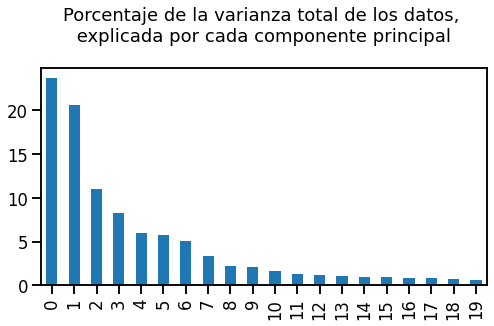

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Porcentaje de la varianza total de los datos, \n explicada por cada componente principal \n")
pd.Series(expl_var).plot(kind='bar')

3. En base al gráfico, seleccione las primeras  m  columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [ ]:
# Varianza explicada de las primeras m componentes
m=4
expl_var[:m].sum()

63.5748

En el gráfico del "Porcentaje de la varianza total de los datos, explicada por cada componente principal (CP)", se destacan las primeras cuatro:

- Primera CP: 23.669 %, 
- Segunda CP: 20.6679 %, 
- Tercera CP: 11.0529 %,  
- Cuarta CP: 8.2593 %.

Entre ellas acumulan un 63.64% de varianza total explicada.

Por ello, se usarán estas cuatro primeras CP en el dataframe final. 

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
# Elegir m componentes
selected_pca = pca_features[:,:m]

In [ ]:
composed_result = numpy.hstack([melb_with_all, selected_pca])
columns=melb_with_all.columns.to_list()
columns.extend(['pca1', 'pca2', 'pca3', 'pca4'])
df_final = pd.DataFrame(data=composed_result, columns=columns)
df_final.head()

,YearBuilt,BuildingArea,Car,Distance,Landsize,Price,Rooms,PriceMonthlyMeanAirbnb,PriceMeanAirbnb,PriceWeeklyMeanAirbnb,Suburb_cat=Suburb_group1,Suburb_cat=Suburb_group10,Suburb_cat=Suburb_group2,Suburb_cat=Suburb_group3,Suburb_cat=Suburb_group4,Suburb_cat=Suburb_group5,Suburb_cat=Suburb_group6,Suburb_cat=Suburb_group7,Suburb_cat=Suburb_group8,Suburb_cat=Suburb_group9,Type=h,Type=t,Type=u,reg_cat=Eastern Metropolitan,reg_cat=Northern Metropolitan,reg_cat=Southern Metropolitan,reg_cat=Victoria,reg_cat=Western Metropolitan,pca1,pca2,pca3,pca4
0,-0.364773,-0.560106,-0.642001,-1.382354,-0.286843,0.657168,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.668336,-0.748737,-1.566600,0.369194
1,-1.786746,-0.752222,-1.726445,-1.382354,-0.319553,-0.054079,-0.997748,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.045063,-1.386701,-2.505017,0.599514
2,-1.786746,0.079499,-1.726445,-1.382354,-0.335197,0.633193,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.743715,-0.115760,-2.695501,0.618639
3,-0.563188,-0.457020,-0.642001,-1.382354,-0.363640,-0.349766,0.093076,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.307620,-0.673439,-1.459172,0.183419
4,1.354823,-0.014216,0.442443,-1.382354,-0.345152,0.848965,1.183899,-0.269126,-0.004562,-0.295736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.380836,0.815257,-0.387451,-0.128175


In [ ]:
df_final.shape

(13466, 32)

In [ ]:
df_final.columns

Index(['YearBuilt', 'BuildingArea', 'Car', 'Distance', 'Landsize', 'Price',
       'Rooms', 'PriceMonthlyMeanAirbnb', 'PriceMeanAirbnb',
       'PriceWeeklyMeanAirbnb', 'Suburb_cat=Suburb_group1',
       'Suburb_cat=Suburb_group10', 'Suburb_cat=Suburb_group2',
       'Suburb_cat=Suburb_group3', 'Suburb_cat=Suburb_group4',
       'Suburb_cat=Suburb_group5', 'Suburb_cat=Suburb_group6',
       'Suburb_cat=Suburb_group7', 'Suburb_cat=Suburb_group8',
       'Suburb_cat=Suburb_group9', 'Type=h', 'Type=t', 'Type=u',
       'reg_cat=Eastern Metropolitan', 'reg_cat=Northern Metropolitan',
       'reg_cat=Southern Metropolitan', 'reg_cat=Victoria',
       'reg_cat=Western Metropolitan', 'pca1', 'pca2', 'pca3', 'pca4'],
      dtype='object')

Guardamos el dataframe de la composición del resultado en un archivo del directorio local.

Se abrirá una ventana emergente para seleccionar el directorio para la descarga.

In [ ]:
from google.colab import files

df_final.to_pickle('df_final.pkl')

files.download('df_final.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 5: Documentación

En un documento .pdf o .md realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:

1. Criterios de exclusión (o inclusión) de filas
2. Interpretación de las columnas presentes
3. Todas las transformaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso.

La documentación se entrega en gitHub en archivo PDF.

-----
FIN